In [28]:
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

sys.path.append('../../')

In [29]:
%load_ext autoreload
%autoreload 2
from analysis.classification_utils.features import FeatureGenerator, TrackClassifier, TrackPlotter


gt_fish_id_yaml = "../../data/labels/Passe3/fish_labels.yaml"

gen = FeatureGenerator(
    gt_fish_id_yaml=gt_fish_id_yaml,
    measurements_csv_dir="../../data/model_output/",
    min_track_length=20, 
    force_feature_recalc=True,
    force_test_feature_recalc=True,
    min_overlapping_ratio=0.5,
    load_old_measurements=False,
    load_old_test_files=False,
    rake_mask_path="../demo/masks/stroppel_rake_front_mask.png",
    flow_area_mask_path="../demo/masks/lavey_flow_area_mask.png",
    trajectory_min_overlap_ratio=0.15,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Calculating/reading features


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Calculating/reading features


0it [00:00, ?it/s]


In [30]:
# TODO: min_track_length=20

In [31]:
gen.calc_feature_dfs()

/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Calculating features for train data


/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/analysis/classification_prototyping/../../analysis/classification_utils/features.py:245: UserWarning: No ground truth data provided. Skipping ground truth mapping.
  warnings.warn("No ground truth data provided. Skipping ground truth mapping.")


Metrics for flow_area
Precision: 0.0
Recall: 0.0
F1 score: 0.0
F2 score: 0.0
Metrics for non_flow_area
Precision: 0.0
Recall: 0.0
F1 score: 0.0
F2 score: 0.0


/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'flow_area': {'confusion_matrix': array([[356, 119],
         [  0,   0]]),
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'fbeta': [0.0]},
 'non_flow_area': {'confusion_matrix': array([[0, 1],
         [0, 0]]),
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'fbeta': [0.0]}}

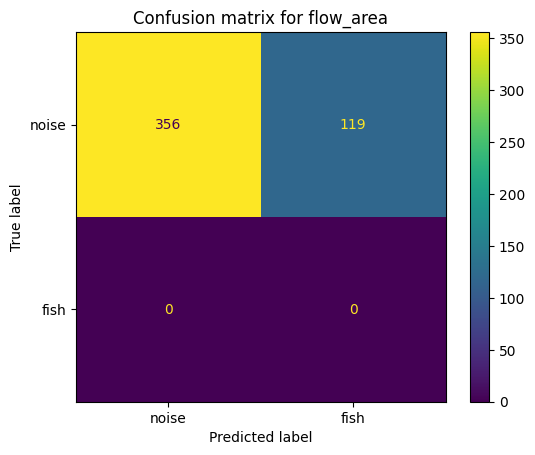

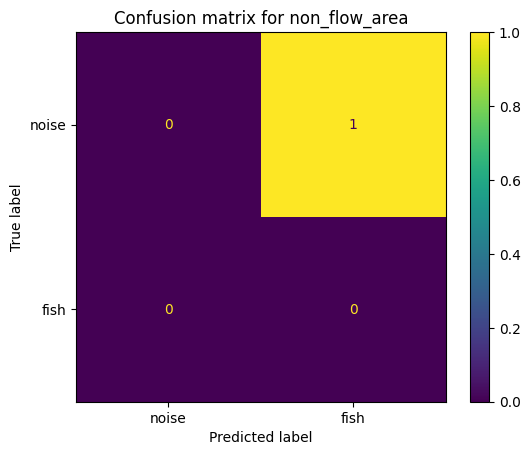

In [32]:
from sklearn.cluster import KMeans

classifier = TrackClassifier(gen.measurements_dfs, gen.test_dfs)

mmts_dfs, test_dfs = classifier.do_clustering(
    features=['average_overlap_ratio', 'average_curvature'],
    clustering_method=KMeans, 
    n_clusters=2,
)

classifier.calculate_metrics(
    make_plots=True, 
    verbosity=1, 
    distinguish_flow_areas=True, 
)

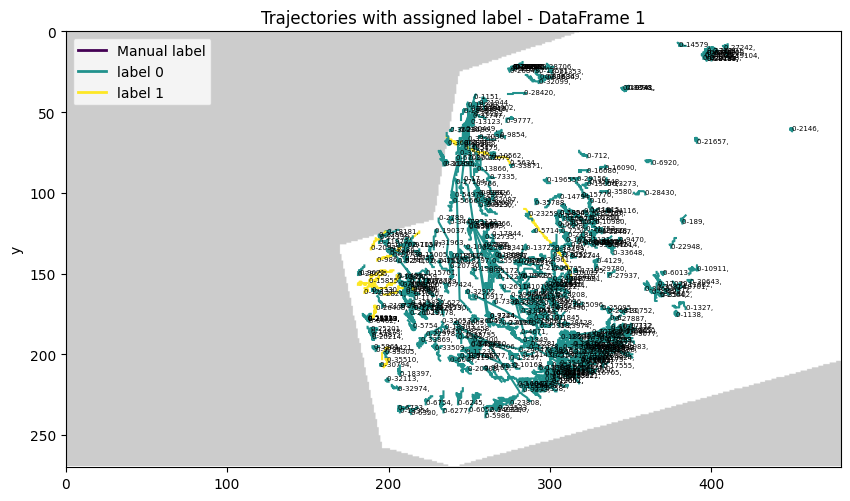

In [33]:
from analysis.classification_utils.features import TrackPlotter

plotter = TrackPlotter(mmts_dfs, gen.masks)

plotter.plot_track_pairings(
    show_track_id=True,
    mask_to_show="flow_area_mask",
    column_with_label="gt_label",
)

In [34]:
import pandas as pd
import numpy as np

def remove_jumps(df, threshold=10):
    # Calculate the Euclidean distance between consecutive points
    df['dist'] = np.sqrt(df['x'].diff()**2 + df['y'].diff()**2)
    
    # Find the indices where the distance is greater than the threshold
    jump_indices = df.index[df['dist'] > threshold].tolist()
    
    # Add the start and end indices of the DataFrame
    jump_indices = [df.index[0]] + jump_indices + [df.index[-1]]
    
    # Split the DataFrame into segments at the jump indices
    segments = [df.loc[jump_indices[i]:jump_indices[i+1]] for i in range(len(jump_indices)-1)]
    
    # Remove the shorter part of the track before or after each jump
    for i in range(1, len(segments)-1):
        if len(segments[i-1]) < len(segments[i+1]):
            segments[i-1] = pd.DataFrame()
        else:
            segments[i+1] = pd.DataFrame()
    
    # Concatenate the segments back into a single DataFrame
    df = pd.concat(segments).drop(columns='dist')
    
    return df

# Apply the function to each DataFrame in mmts_dfs
mmts_dfs = [remove_jumps(df) for df in mmts_dfs]

plotter = TrackPlotter(mmts_dfs, gen.masks)

In [35]:
feature_df = pd.concat(mmts_dfs).groupby('id').first().select_dtypes(include=[np.number])
feature_df.drop(
    columns=[
        'x_avg', 'v_xr_avg', 'x', 'v_x', 'v_xr', 'v_xr_median',
        'y_avg', 'v_yr_avg', 'y', 'v_y', 'v_yr', 'v_yr_median',
        'video_id',
    ], 
    inplace=True
)

# Check for NaN values in the DataFrame
nan_values = feature_df.isna()
nan_counts = feature_df.isna().sum()

# Print the columns that have NaN values
print(nan_counts)

# drop rows with NaN values
feature_df = feature_df.dropna()

frame                                              0
w                                                  0
h                                                  0
contour_area                                       0
stddev_of_intensity                                0
tile_blob_counts                                   0
v_smoothed_avg                                    11
v_smoothed_std                                    11
v_10th_percentile                                 11
v_30th_percentile                                 11
v_50th_percentile                                 11
v_70th_percentile                                 11
v_90th_percentile                                 11
v_95th_percentile                                 11
v_99th_percentile                                 11
v_parallel_river_avg                               0
v_orthogonal_river_avg                             0
v_orthogonal_abs_sum                               0
v_orthogonal_abs_avg                          

In [36]:
feature_df

frame  w   h  contour_area  stddev_of_intensity  tile_blob_counts  \
id                                                                           
0-10244   1843  4   5            20            12.537942                 0   
0-10500   1880  9  16           144            16.153482                 1   
0-10547   1885  3   4            12             6.383029                 0   
0-10580   1892  3   4            12             7.123903                 0   
0-1060     385  7   6            42             6.511110                 0   
...        ... ..  ..           ...                  ...               ...   
0-9854    1782  5   5            25             6.092618                 0   
0-986      375  3   4            12             9.656244                 0   
0-988      375  3   3             9             9.170538                 0   
0-9890    1788  3   3             9            12.038006                 0   
0-9896    1789  3   4            12             5.845226                 0   

         v_smoothed_avg  v_smoothed_std  v_10th_percentile  v_30th_percentile  \
id                                                                              
0-10244        0.219855        0.104861           0.112427           0.150616   
0-10500        0.138547        0.064372           0.049786           0.109201   
0-10547        0.254127        0.106729           0.142515           0.190717   
0-10580        0.159839        0.106622           0.064439           0.102918   
0-1060         0.149643        0.091072           0.053493           0.083635   
...                 ...             ...                ...                ...   
0-9854         0.193001        0.168686           0.036215           0.091601   
0-986          0.406538        0.082592           0.314368           0.350273   
0-988          0.136170        0.074596           0.079255           0.098047   
0-9890         0.157870        0.102235           0.053576           0.093406   
0-9896         0.098442        0.084451           0.023990           0.053237   

         ...  dist_near_rake  flow_area_time_ratio  \
id       ...                                         
0-10244  ...        0.000000                   1.0   
0-10500  ...        0.000000                   1.0   
0-10547  ...        0.000000                   1.0   
0-10580  ...        0.000000                   1.0   
0-1060   ...        0.000000                   1.0   
...      ...             ...                   ...   
0-9854   ...       48.086408                   1.0   
0-986    ...        0.000000                   1.0   
0-988    ...        0.000000                   1.0   
0-9890   ...        0.000000                   1.0   
0-9896   ...       15.656854                   1.0   

         average_distance_from_start  average_contour_area  \
id                                                           
0-10244                    13.347943             29.274648   
0-10500                     3.454874             25.838710   
0-10547                     3.827357             21.166667   
0-10580                     3.854376             23.466667   
0-1060                      3.054954             29.461538   
...                              ...                   ...   
0-9854                      2.012284             28.666667   
0-986                      14.881035             35.271605   
0-988                       2.796632             15.651685   
0-9890                      4.779234             26.939130   
0-9896                      1.208585             14.735294   

         distance_between_starting_and_ending_point  average_pixel_intensity  \
id                                                                             
0-10244                                   23.194827               137.467536   
0-10500                                    7.211103               142.421038   
0-10547                                    6.000000               132.594938   
0-10580                       

In [37]:
from sklearn.ensemble import RandomForestClassifier

# Assuming feature_dfs is your DataFrame and 'gt_label' is your target variable
X = feature_df.drop('gt_label', axis=1)
y = feature_df['gt_label']

# Initialize the model
model = RandomForestClassifier(random_state=1)

# Fit the model
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Sort by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

print(feature_importances)

                                           feature  importance
37                         average_pixel_intensity    0.078809
25                   average_smoothed_curvature_25    0.064076
15                            v_parallel_river_avg    0.052744
16                          v_orthogonal_river_avg    0.048196
24                   average_smoothed_curvature_15    0.047915
4                              stddev_of_intensity    0.047303
11                               v_70th_percentile    0.039562
20                       v_orthogonal_river_median    0.037342
8                                v_10th_percentile    0.034296
9                                v_30th_percentile    0.033011
22                                      frame_diff    0.032911
13                               v_95th_percentile    0.031740
6                                   v_smoothed_avg    0.031001
0                                            frame    0.029737
21                              traversed_distance    0

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import numpy as np

# Define the classifiers
classifiers = {
    'logistic_regression': LogisticRegression(random_state=2, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=2, class_weight='balanced'),
    'SVM': SVC(random_state=2, class_weight='balanced')
}

# Define the cross-validation
X = feature_df[['average_pixel_intensity', 'v_90th_percentile', 'distance_between_starting_and_ending_point', 'average_overlap_ratio']]
# current best: ['average_pixel_intensity', 'v_90th_percentile', 'distance_between_starting_and_ending_point', 'average_overlap_ratio']
num_fish = y.sum()  # Assuming y is your target variable
cv = StratifiedKFold(n_splits=num_fish)

# Evaluate each model
y_pred = {}
for name, classifier in classifiers.items():
    y_pred[name] = np.zeros(y.shape)
    confusion_matrices = []
    
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        classifier.fit(X_train, y_train)
        predictions = classifier.predict(X_test)
        y_pred[name][test_index] = predictions
        confusion = confusion_matrix(y_test, predictions)
        confusion_matrices.append(confusion)
    
    summed_confusion = np.sum(confusion_matrices, axis=0)
    
    # Calculate metrics from the summed confusion matrix
    tn, fp, fn, tp = summed_confusion.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    print(f'{name}:')
    print(f'  Accuracy: {accuracy}')
    print(f'  Precision: {precision}')
    print(f'  Recall: {recall}')
    print(f'  Summed Confusion Matrix:')
    print(summed_confusion)
    
y_pred = pd.DataFrame(y_pred, index=feature_df.index)

logistic_regression:
  Accuracy: 0.89419795221843
  Precision: 0.19444444444444445
  Recall: 0.7777777777777778
  Summed Confusion Matrix:
[[255  29]
 [  2   7]]
Random Forest:
  Accuracy: 0.9726962457337884
  Precision: 1.0
  Recall: 0.1111111111111111
  Summed Confusion Matrix:
[[284   0]
 [  8   1]]
SVM:
  Accuracy: 0.8873720136518771
  Precision: 0.14705882352941177
  Recall: 0.5555555555555556
  Summed Confusion Matrix:
[[255  29]
 [  4   5]]


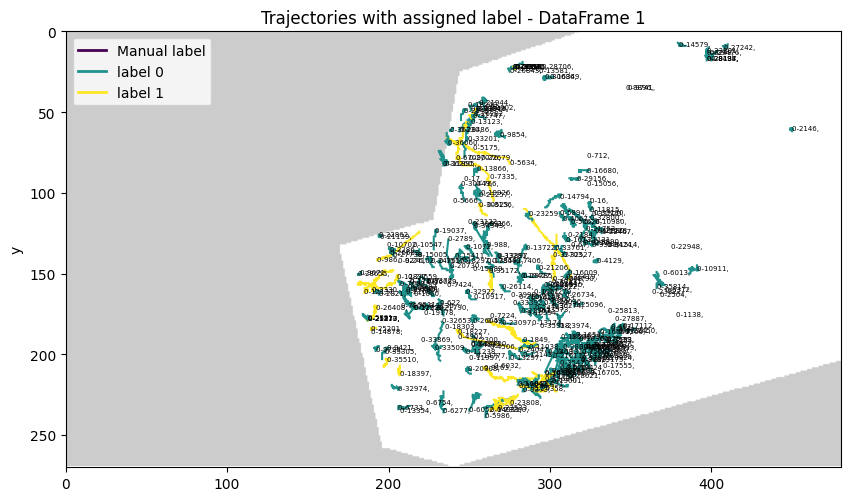

In [39]:
plotter.overwrite_classification_v2(y_pred)

plotter.plot_track_pairings(
    show_track_id=True,
    mask_to_show="flow_area_mask",
    column_with_label="logistic_regression",
)

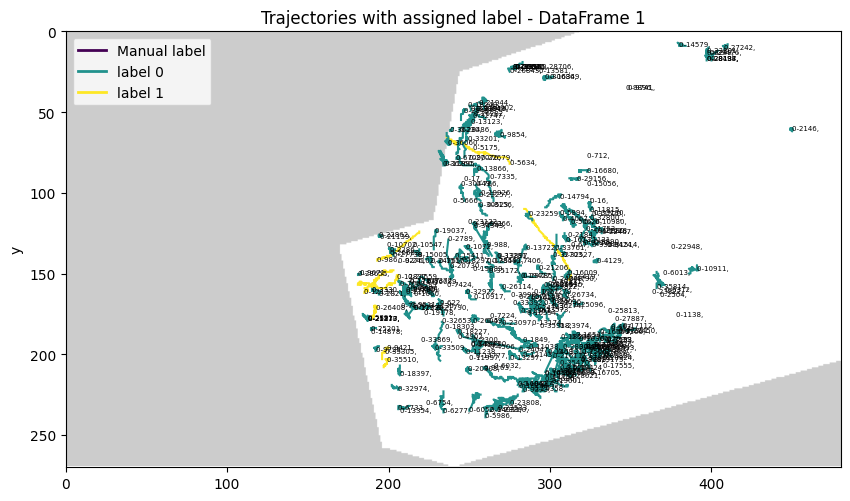

In [40]:
plotter.plot_track_pairings(
    show_track_id=True,
    mask_to_show="flow_area_mask",
    column_with_label="gt_label",
)

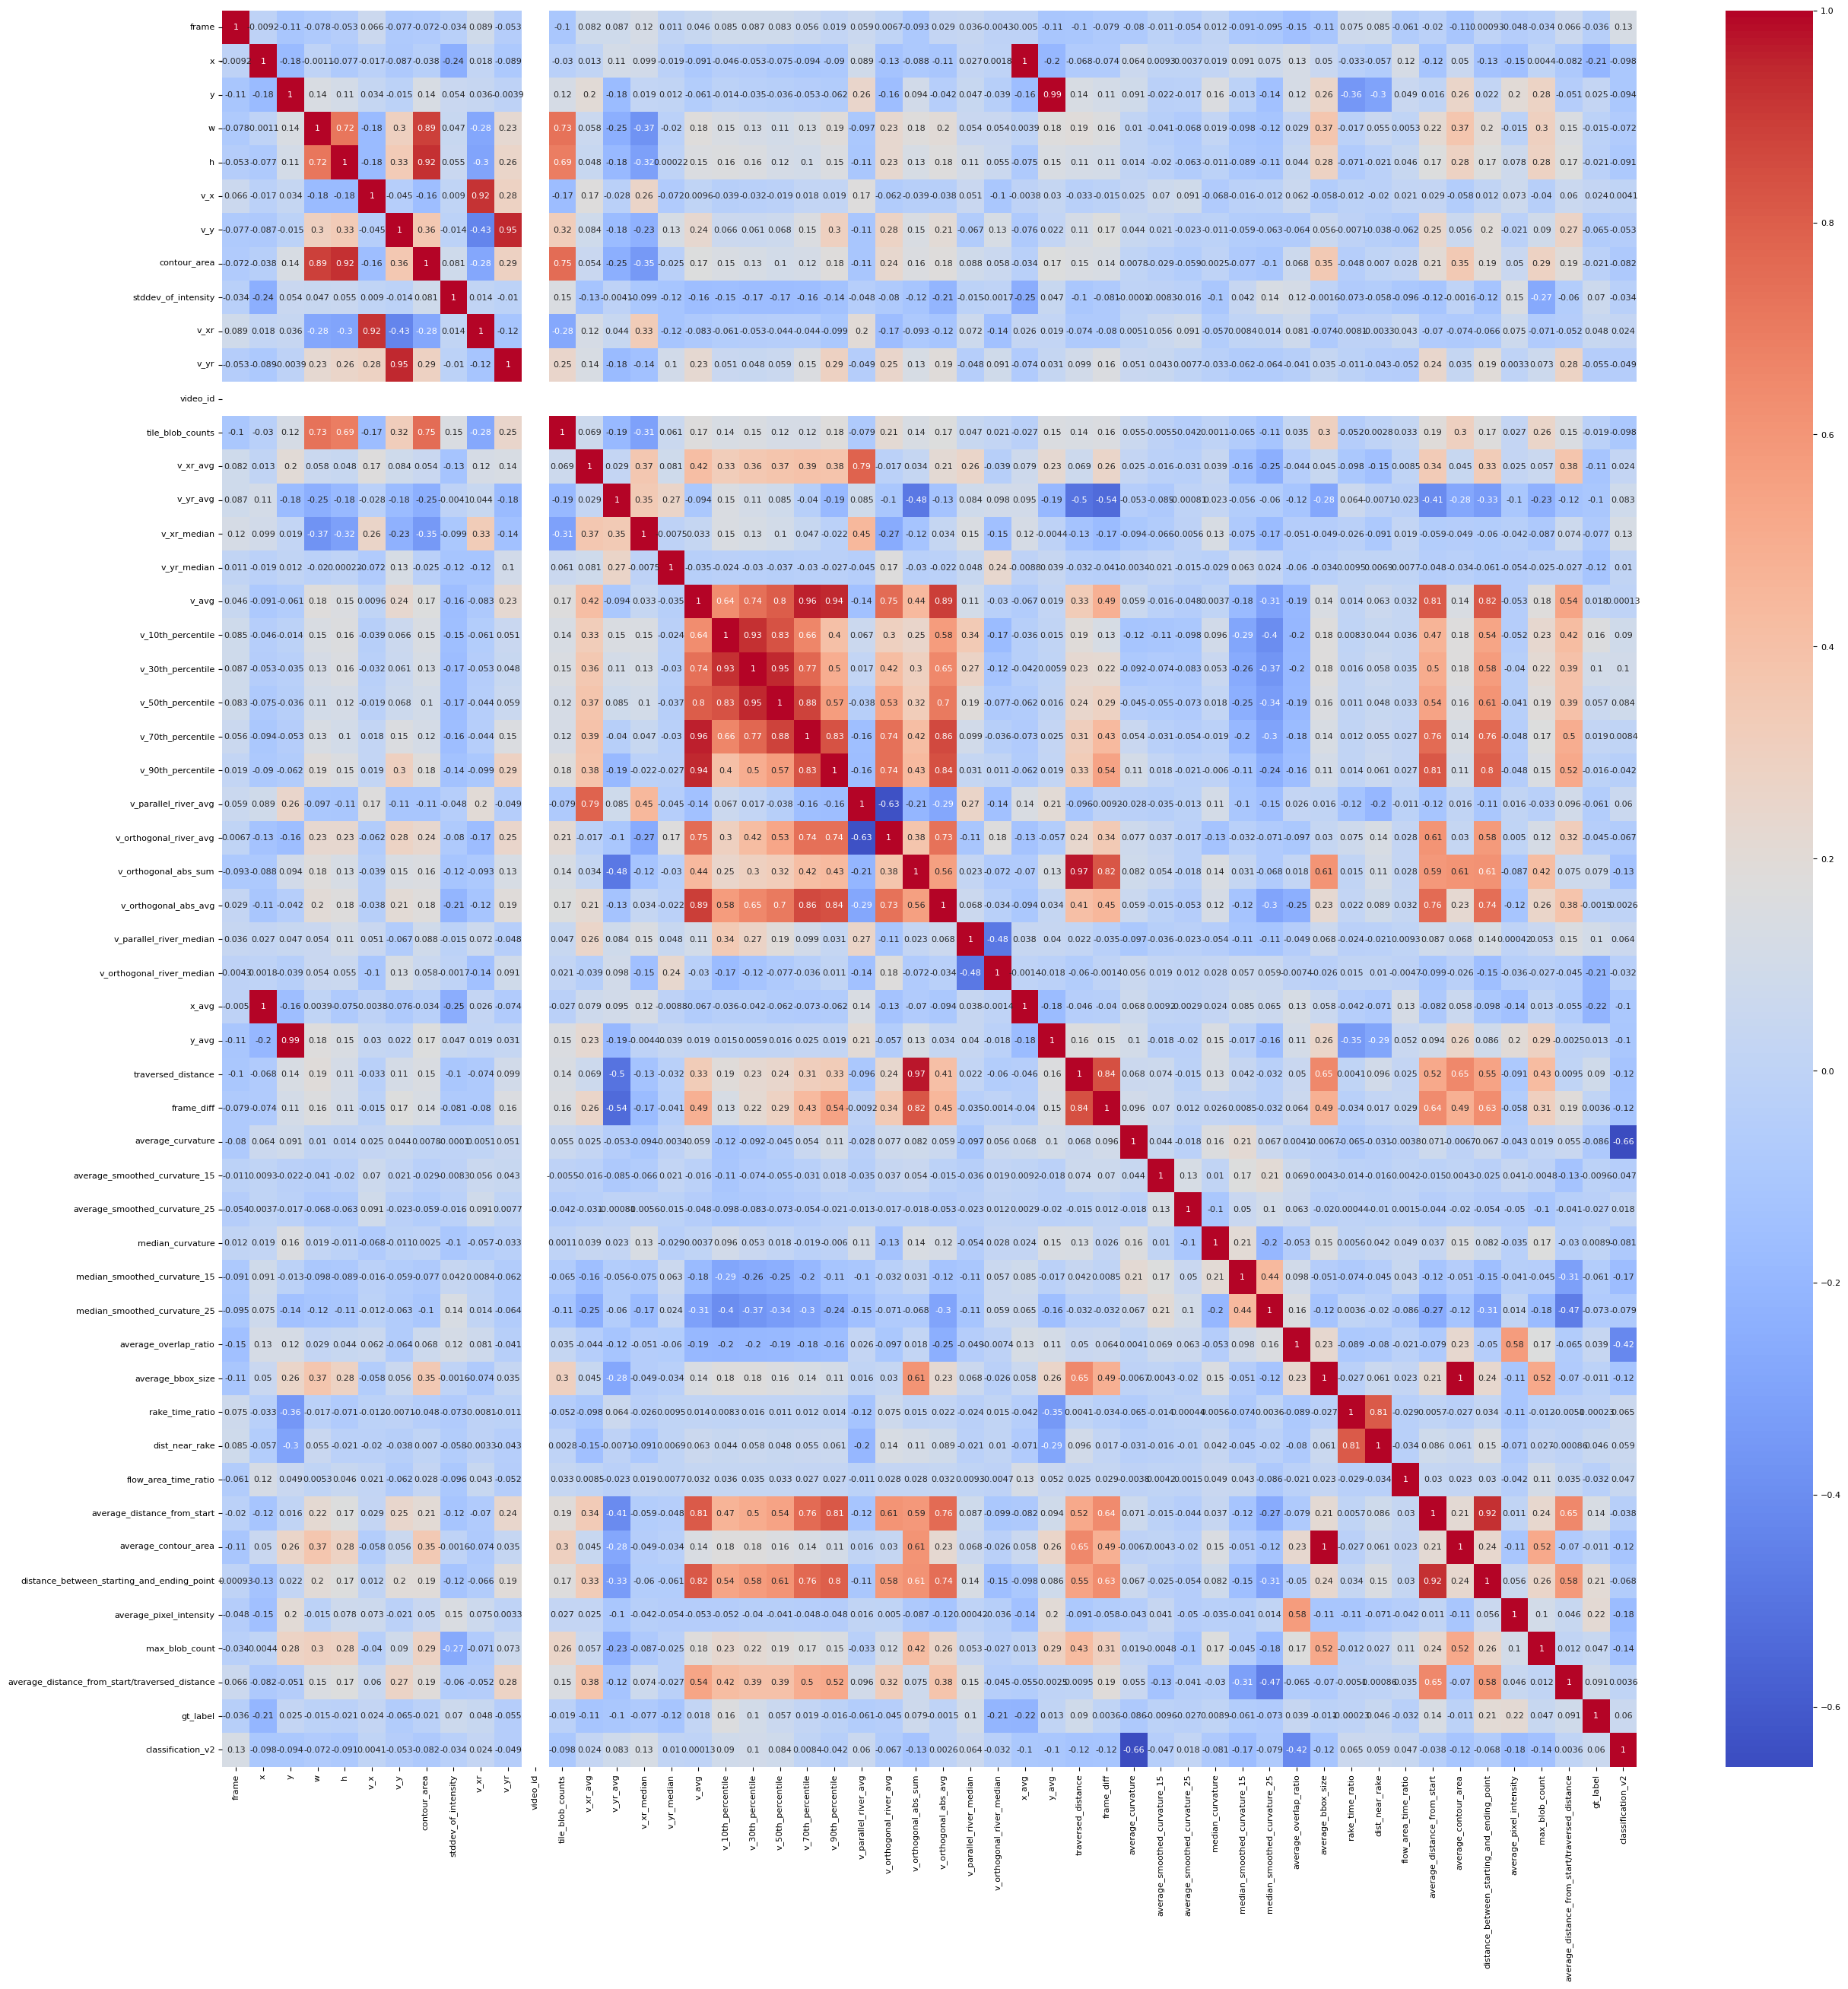

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(30, 30))

# Compute the correlation matrix
corr_matrix = feature_df.corr()

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={"fontsize":8})

# Show the plot
plt.show()

In [ ]:
# TODO: check if river velocity breaks stuff
# TODO: check out why some tracks are not saved during tracking
# TODO: do plots of features with class in different color
# TODO: do classification
# TODO: calculate principal components and do classification

In [33]:
mmts_dfs[0][mmts_dfs[0]['id'] == '0-5709']

Empty DataFrame
Columns: [frame, id, x, y, w, h, v_x, v_y, contour_area, image_tile, stddev_of_intensity, v_xr, v_yr, classification, video_id, video_name, binary_image, tile_blob_counts, v_xr_avg, v_yr_avg, v_xr_median, v_yr_median, v_avg, v_10th_percentile, v_30th_percentile, v_50th_percentile, v_70th_percentile, v_90th_percentile, v_parallel_river_avg, v_orthogonal_river_avg, v_orthogonal_abs_sum, v_orthogonal_abs_avg, v_parallel_river_median, v_orthogonal_river_median, x_avg, y_avg, traversed_distance, frame_diff, average_curvature, average_smoothed_curvature_15, average_smoothed_curvature_30, median_curvature, median_smoothed_curvature_15, median_smoothed_curvature_30, average_overlap_ratio, average_bbox_size, rake_time_ratio, dist_near_rake, flow_area_time_ratio, average_distance_from_start, average_contour_area, distance_between_starting_and_ending_point, average_pixel_intensity, max_blob_count, average_distance_from_start/traversed_distance, gt_label, gt_trajectory_id, classification_v2]
Index: []

[0 rows x 58 columns]

Metrics for flow_area
Precision: 0.0
Recall: 0.0
F1 score: 0.0
F2 score: 0.0
F3 score: 0.0
Metrics for non_flow_area
Precision: 0.0
Recall: 0.0
F1 score: 0.0
F2 score: 0.0
F3 score: 0.0


/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nicolaspelzmann/Documents/projects/MTA/AXH-SonarFish/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

{'flow_area': {'confusion_matrix': array([[  0, 322],
         [  0,   0]]),
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'fbeta': [0.0, 0.0]},
 'non_flow_area': {'confusion_matrix': array([[0, 0],
         [0, 0]]),
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'fbeta': [0.0, 0.0]}}

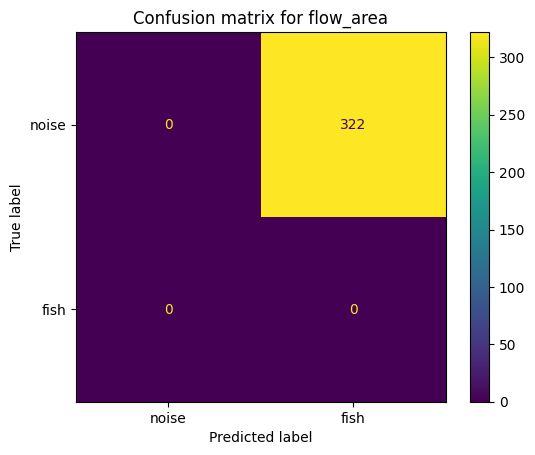

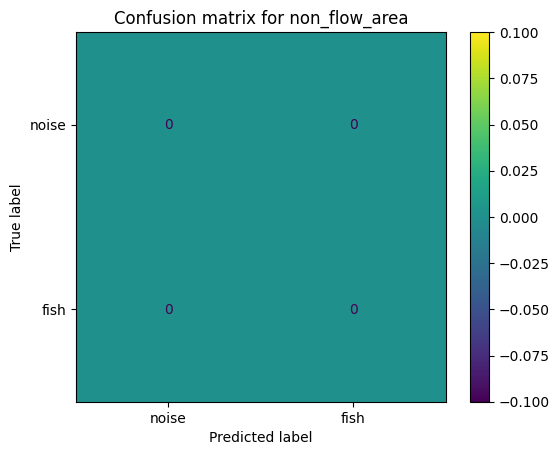

In [5]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

gen.do_binary_classification(
    LogisticRegression(class_weight="balanced"), 
    kfold_n_splits=9,
    features=['median_smoothed_curvature_30', 'average_overlap_ratio', 'average_bbox_size'],
    manual_noise_thresholds=[
        ("average_distance_from_start/traversed_distance", "smaller", 0.08),
    ],
    features_flow_area=[],
    manual_noise_thresholds_flow_area=[
        ("median_curvature", "larger", -1.0),
    ],
    class_overrides_flow_area=[
        ("v_avg", "larger", 0.05, 1),
    ]
)

gen.calculate_metrics(
    beta_vals=[2, 3], 
    make_plots=True, 
    verbosity=1, 
    distinguish_flow_areas=True, 
    evaluate_test_data=True,
)

In [6]:
fish_ids = [
    "0-1232", 
    "0-6634", 
    "0-7875", # only short
    "0-8225", # only short
    "0-14359",
    "0-14694",
    "0-23977",
    "0-33992",
]
missed_fish = 3

In [7]:
test_df = gen.test_dfs[0].copy()

In [8]:
test_df['gt_label'] = 0
test_df.loc[test_df['id'].isin(fish_ids), 'gt_label'] = 1
test_df['v_10th_90th_diff'] = test_df['v_90th_percentile'] - test_df['v_10th_percentile']

test_single_row_df = test_df.groupby('id').first().reset_index()

/tmp/ipykernel_141328/2748870059.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = test_single_row_df.corr()


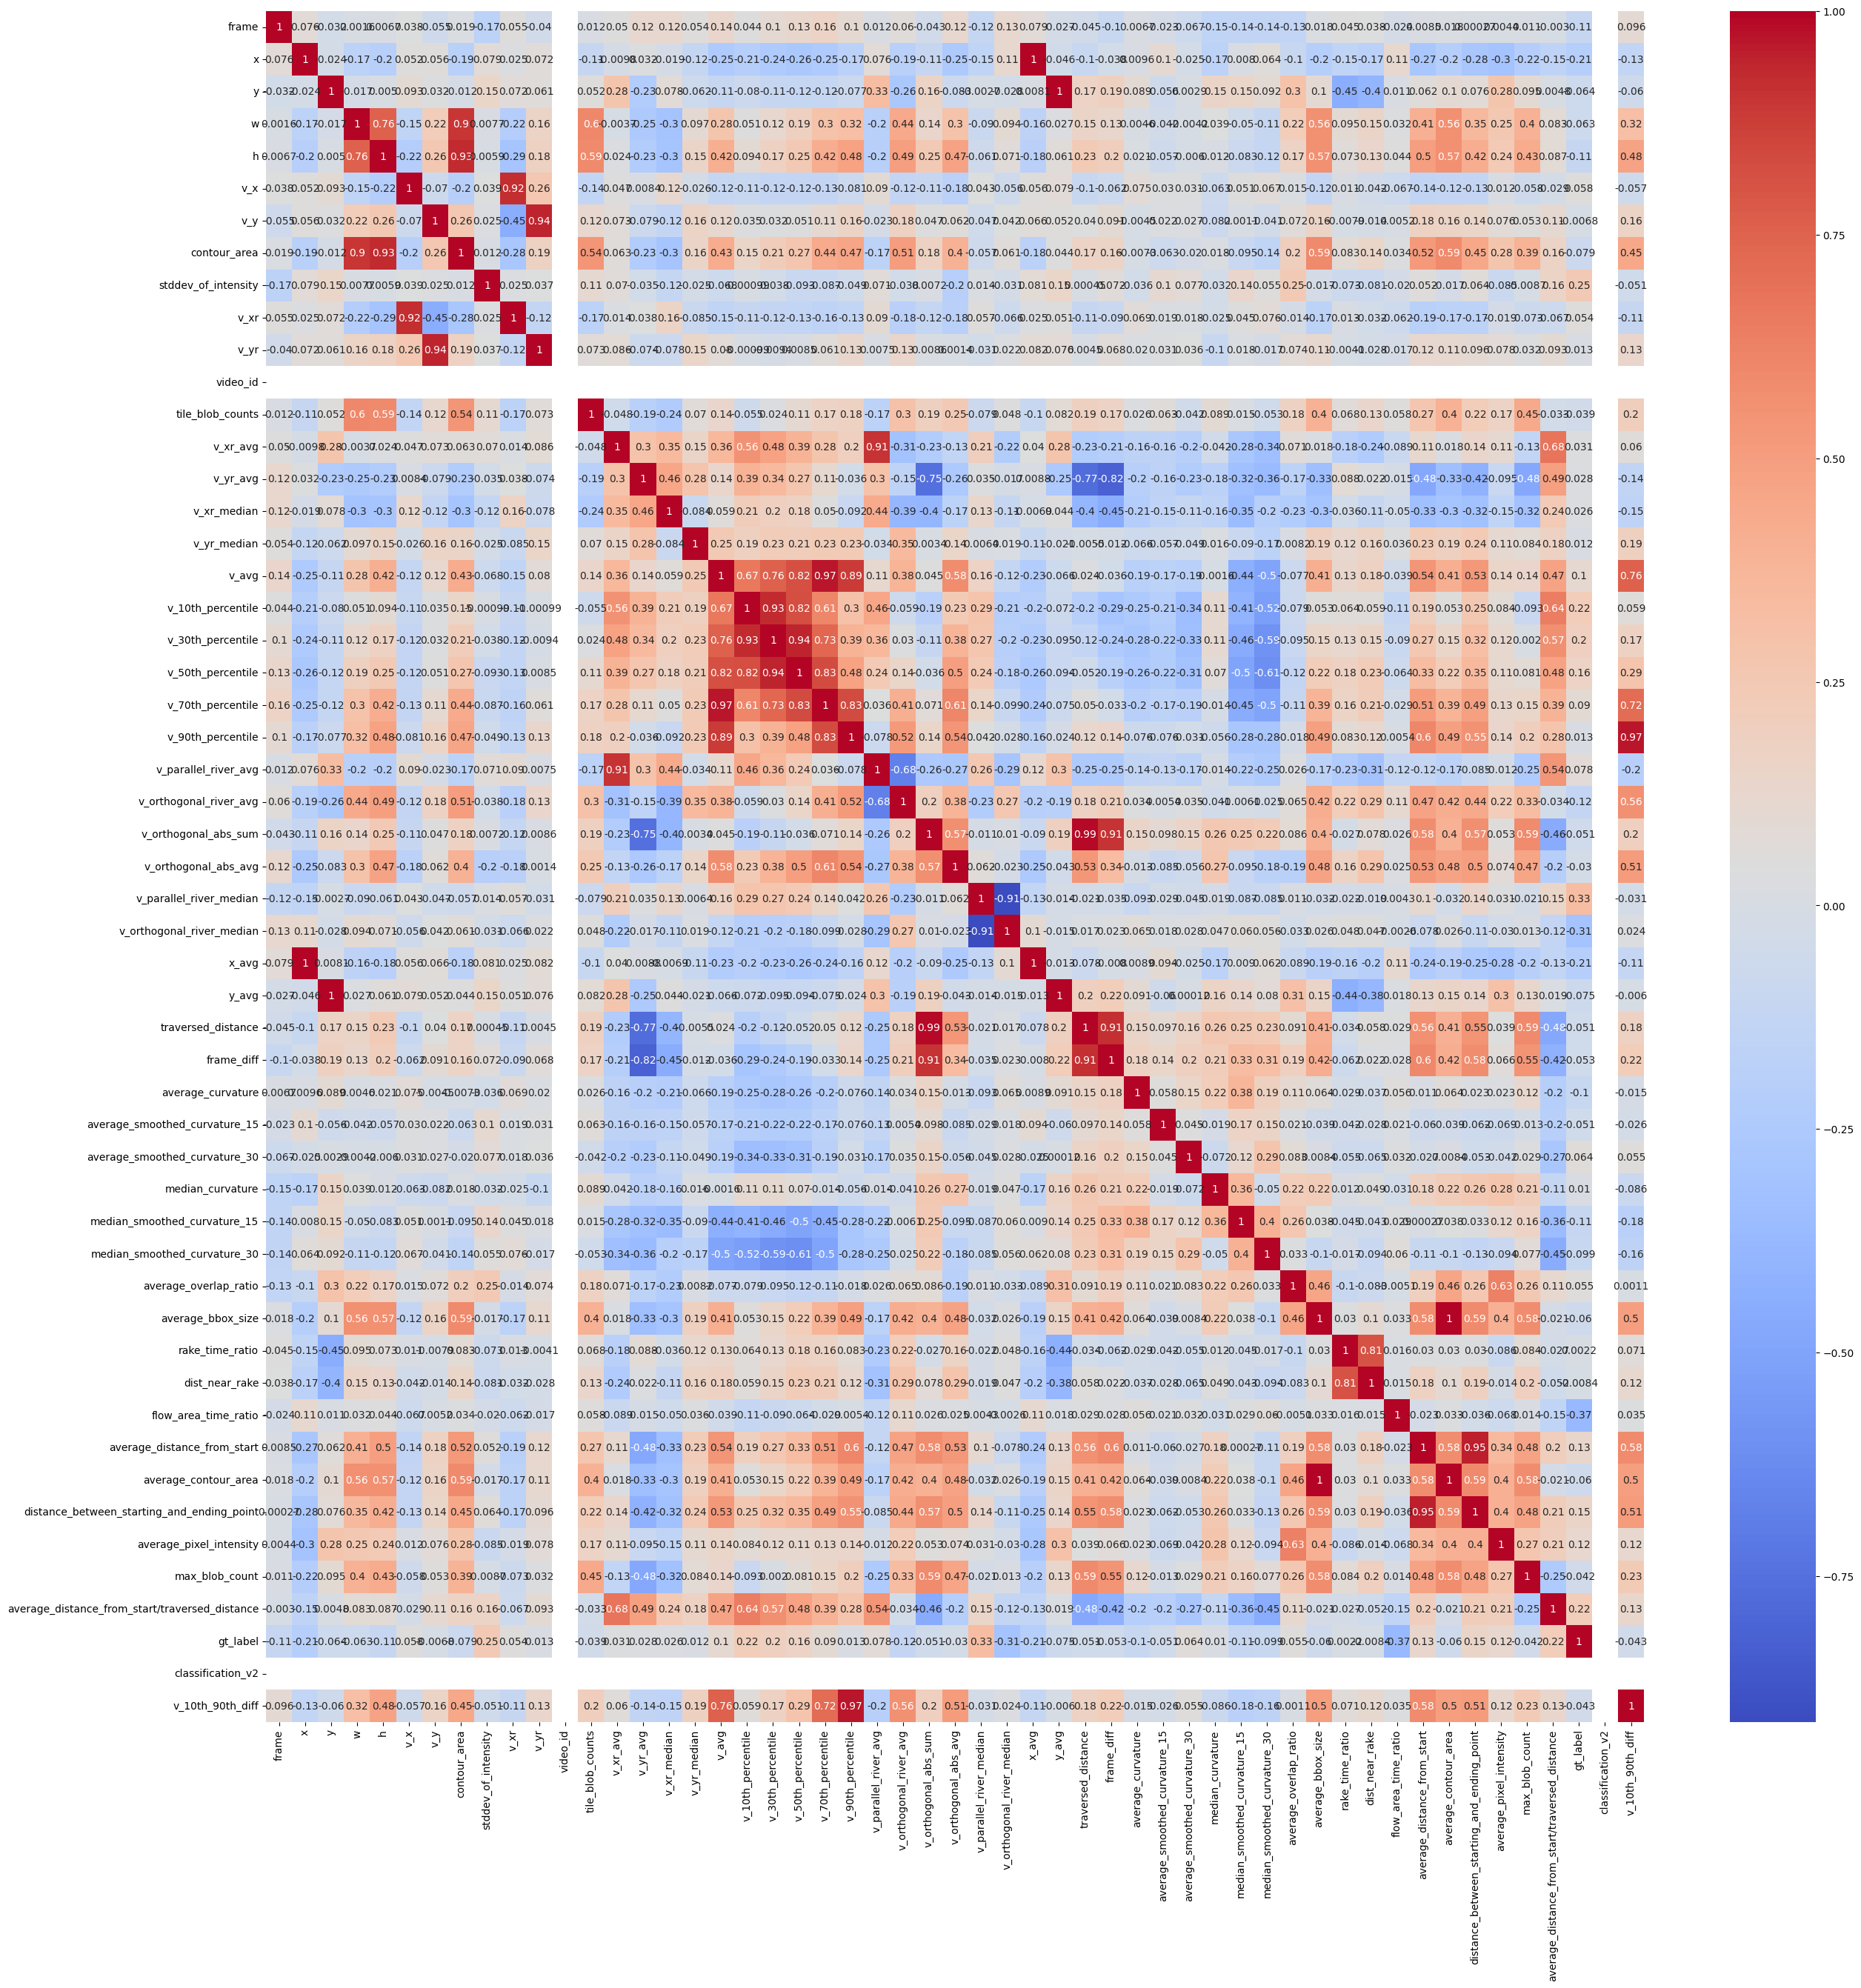

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(30, 30))

# Compute the correlation matrix
corr_matrix = test_single_row_df.corr()

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Show the plot
plt.show()

In [12]:
features = [
    "id",
    "stddev_of_intensity",
    "v_10th_percentile",
    "v_10th_90th_diff",
    "average_distance_from_start/traversed_distance",
    "gt_label",
]

test_single_row_df[test_single_row_df['id'].isin(fish_ids)][features]

id  stddev_of_intensity  v_10th_percentile  v_10th_90th_diff  \
28    0-1232            21.073120           0.318259          0.206976   
48   0-14359            61.187496           0.246085          0.133829   
50   0-14694            14.132741           0.184463          0.155801   
126  0-23977            20.623955           0.226352          0.124843   
295   0-6634            41.796344           0.175873          0.291790   
303   0-7875            33.203711           0.157267          0.165146   
306   0-8225            49.040009           0.019854          0.404979   

     average_distance_from_start/traversed_distance  gt_label  
28                                         0.284718         1  
48                                         0.296638         1  
50                                         0.218871         1  
126                                        0.363938         1  
295                                        0.228271         1  
303                                        0.237638         1  
306                                        0.221928         1

In [ ]:
#TODO: push this to github instead of devops

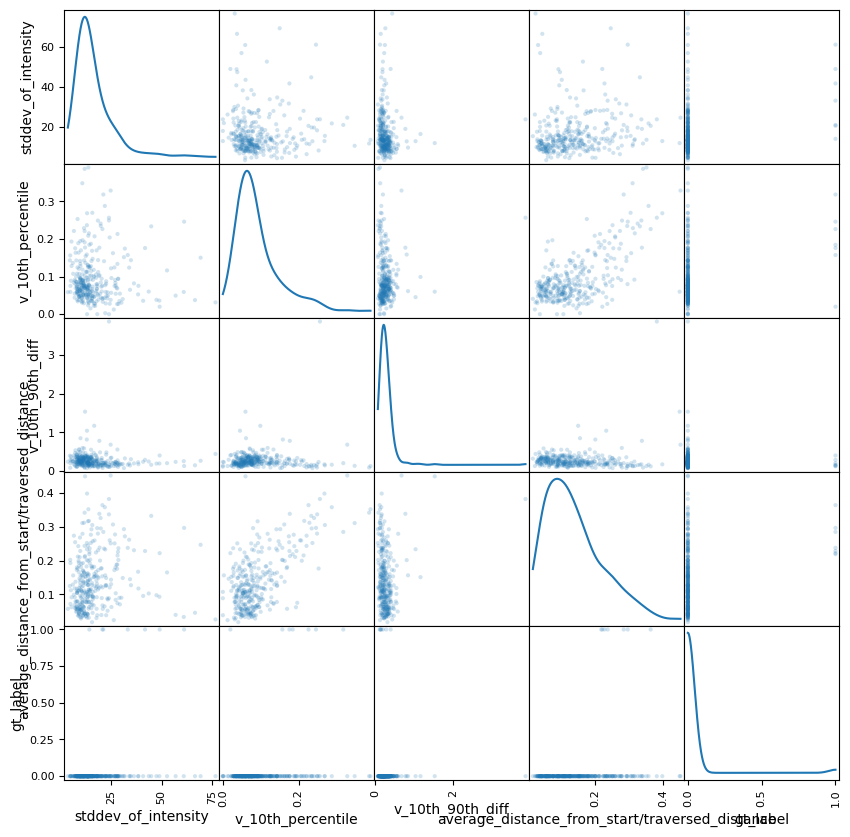

In [13]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

plot_features = features[1:]

# Create a scatter matrix
scatter_matrix(test_single_row_df[plot_features], alpha=0.2, figsize=(10, 10), diagonal='kde

# Show the plot
plt.show()

In [147]:
test_df[test_df['v_10th_90th_diff'] < 0.17][features].groupby("id").first()

v_avg  v_10th_percentile  v_30th_percentile  v_50th_percentile  \
id                                                                           
0-10596  0.111352           0.041482           0.075833           0.104984   
0-10996  0.273872           0.194420           0.237183           0.266103   
0-12114  0.150386           0.086313           0.144244           0.160177   
0-12403  0.133662           0.064867           0.098995           0.118815   
0-12539  0.099558           0.023477           0.067450           0.076224   
...           ...                ...                ...                ...   
0-8147   0.354043           0.269637           0.342551           0.353763   
0-825    0.119089           0.054294           0.077634           0.108280   
0-837    0.123792           0.063218           0.087980           0.109855   
0-9670   0.136985           0.054668           0.075814           0.100292   
0-9882   0.146840           0.075295           0.115681           0.135868   

         v_70th_percentile  v_90th_percentile  v_10th_90th_diff gt_label  
id                                                                        
0-10596           0.133122           0.195616          0.154134    noise  
0-10996           0.306518           0.363949          0.169529    noise  
0-12114           0.170551           0.198782          0.112469    noise  
0-12403           0.148076           0.213231          0.148364    noise  
0-12539           0.122510           0.169180          0.145703    noise  
...                    ...                ...               ...      ...  
0-8147            0.382494           0.419310          0.149673    noise  
0-825             0.146528           0.197858          0.143564    noise  
0-837             0.143200           0.213783          0.150566    noise  
0-9670            0.152203           0.211164          0.156495    noise  
0-9882            0.172701           0.235077          0.159782    noise  

[64 rows x 8 columns]

In [152]:
test_df[features].groupby("id").first()

v_avg  v_10th_percentile  v_30th_percentile  v_50th_percentile  \
id                                                                           
0-10034  0.185991           0.031355           0.072179           0.116128   
0-10066  0.190930           0.076032           0.141440           0.185565   
0-10090  0.299637           0.105984           0.160574           0.308751   
0-10137  0.220814           0.066327           0.129642           0.192417   
0-102    0.221749           0.072263           0.135393           0.188297   
...           ...                ...                ...                ...   
0-9429   0.193242           0.113066           0.142488           0.170864   
0-9670   0.136985           0.054668           0.075814           0.100292   
0-981    0.198086           0.096394           0.135787           0.168985   
0-9882   0.146840           0.075295           0.115681           0.135868   
0-991    0.197239           0.084230           0.137436           0.181097   

         v_70th_percentile  v_90th_percentile  v_10th_90th_diff  \
id                                                                
0-10034           0.197035           0.476456          0.445101   
0-10066           0.229837           0.335894          0.259862   
0-10090           0.397838           0.503538          0.397555   
0-10137           0.266269           0.422701          0.356374   
0-102             0.279668           0.398509          0.326246   
...                    ...                ...               ...   
0-9429            0.198558           0.316470          0.203404   
0-9670            0.152203           0.211164          0.156495   
0-981             0.228980           0.339784          0.243390   
0-9882            0.172701           0.235077          0.159782   
0-991             0.241921           0.296229          0.211999   

         average_distance_from_start  average_overlap_ratio gt_label  
id                                                                    
0-10034                     6.385074               3.155197    noise  
0-10066                     2.069427               3.114421    noise  
0-10090                     4.843371               0.666280    noise  
0-10137                    18.705833               1.610621    noise  
0-102                       6.004379               2.183986    noise  
...                              ...                    ...      ...  
0-9429                      3.163923               1.049702    noise  
0-9670                      2.956055               2.234657    noise  
0-981                       6.941361               0.872919    noise  
0-9882                      2.426662               1.352715    noise  
0-991                       7.472009               2.285601    noise  

[322 rows x 10 columns]

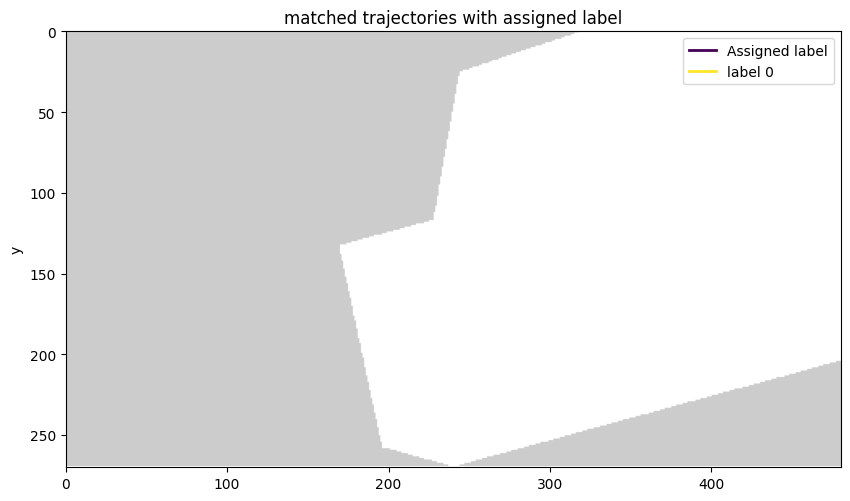

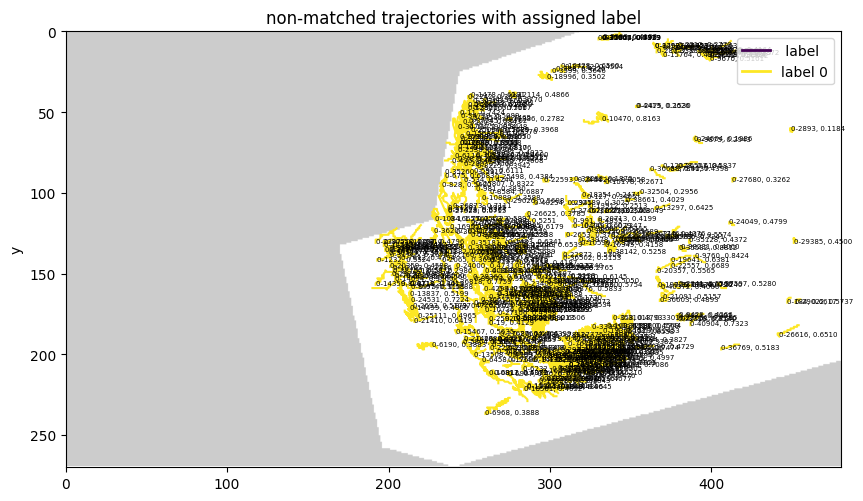

In [94]:
gen.plot_track_pairings(
    metric_to_show="v_avg", 
    mask_to_show="flow_area_mask", 
    show_track_id=True,
    plot_test_data=True,
)

In [49]:
gen.save_classified_tracks_to_csv()

# Evaluate Leiv's Version's Output

Metrics for flow_area
Precision: 0.2830188679245283
Recall: 0.5
F1 score: 0.3614457831325301
F2 score: 0.43352601156069365
F3 score: 0.46439628482972134
Metrics for non_flow_area
Precision: 0.3142857142857143
Recall: 0.7857142857142857
F1 score: 0.44897959183673464
F2 score: 0.6043956043956044
F3 score: 0.6832298136645963


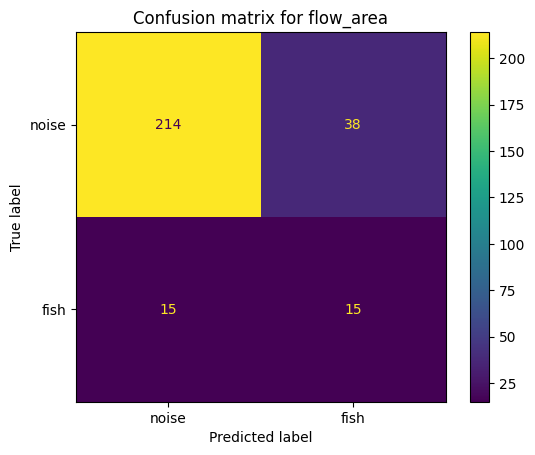

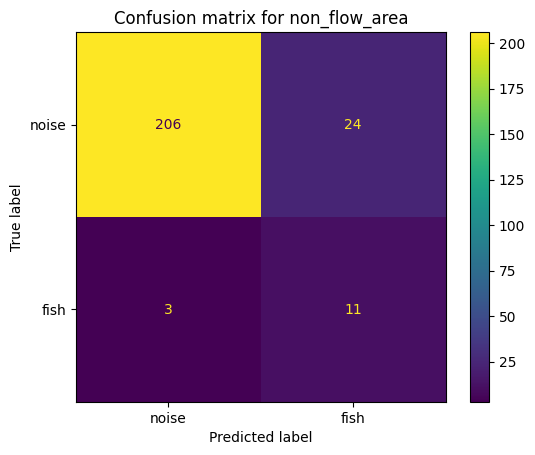

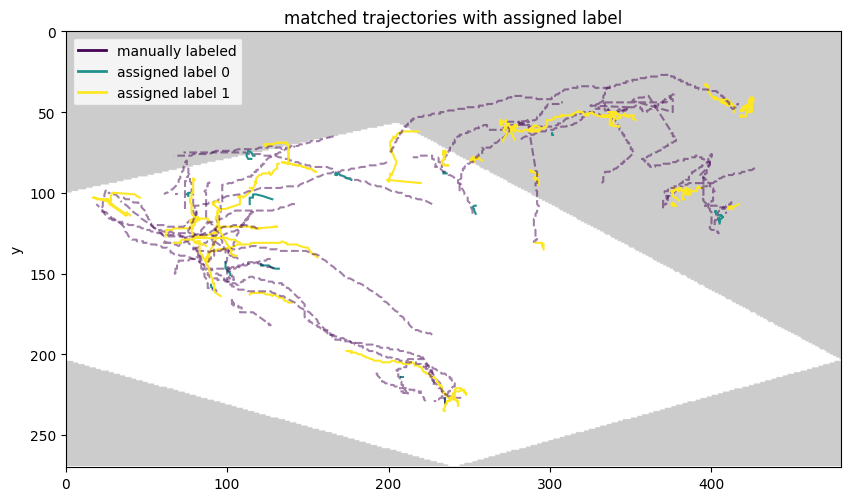

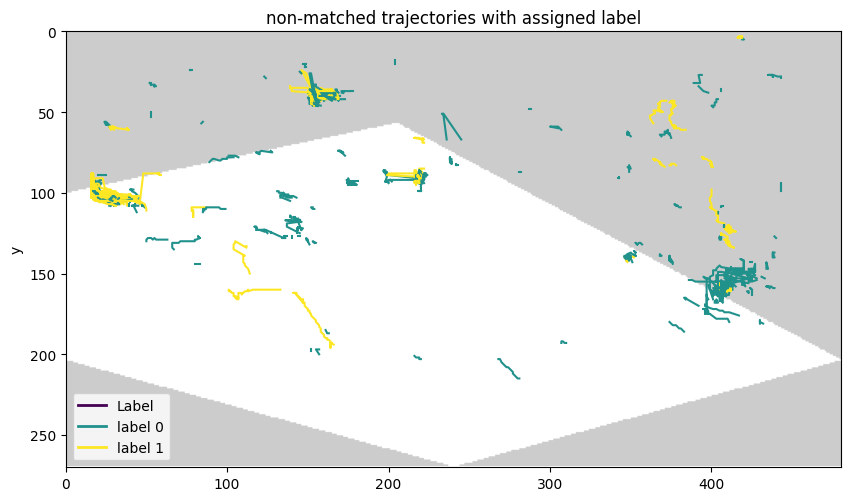

In [374]:
gen.calculate_metrics(
    beta_vals=[2, 3], 
    make_plots=True, 
    verbosity=1, 
    distinguish_flow_areas=True, 
    evaluate_test_data=True,
    normalize_confusion_matrix=None,
)
gen.plot_track_pairings(
    mask_to_show="flow_area_mask", 
    plot_test_data=True, 
    show_track_id=False,
)

In [19]:
sum(gen.test_dfs[1].classification != 'fish')

0

In [364]:
gen.sweep_classification_feature_selection(
    model=LogisticRegression(class_weight="balanced"),
    max_n_features=3,
    distinguish_flow_areas=True,
    kfold_n_splits=10,
)

(['v_xr', 'v_yr', 'average_smoothed_curvature_30'], 0.6024096385542168)

In [ ]:
gen.sweep_classification_feature_selection(
    LogisticRegression(class_weight="balanced"), 
    distinguish_flow_areas=True,
)

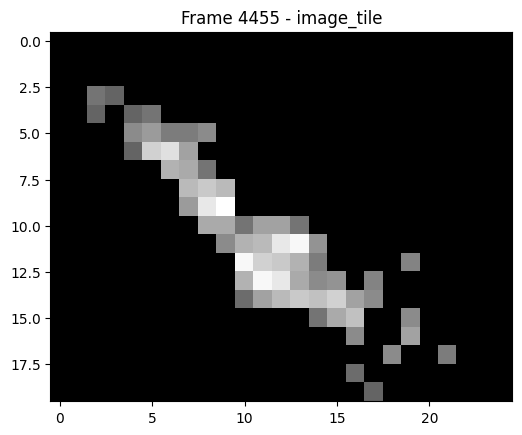

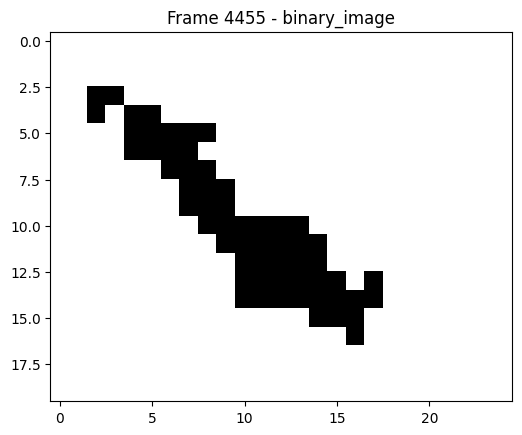

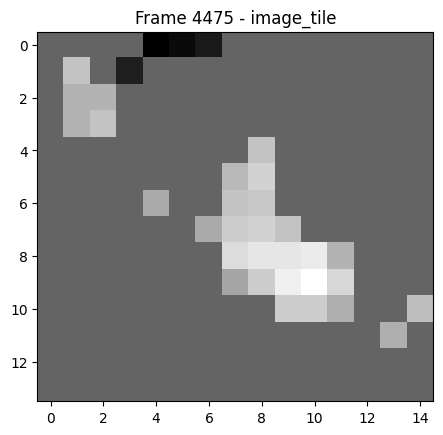

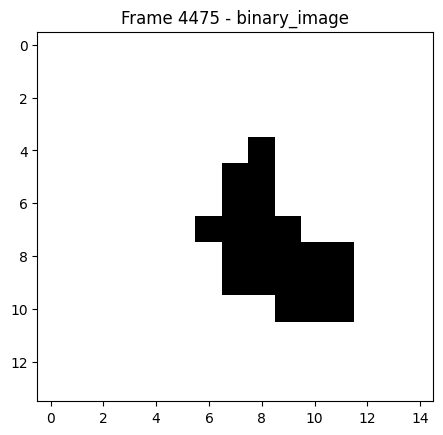

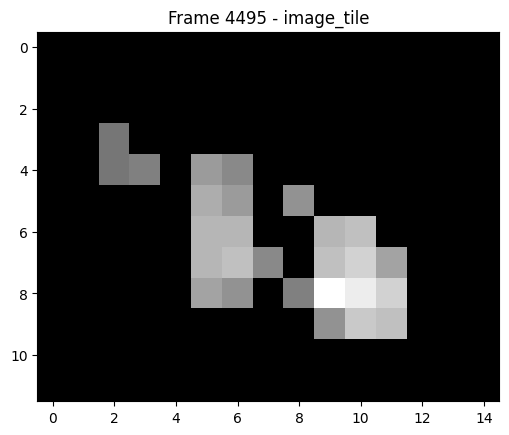

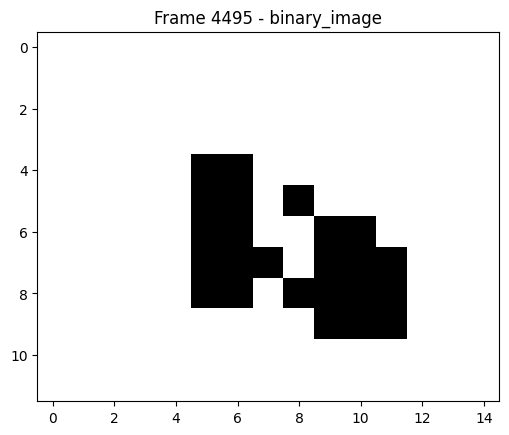

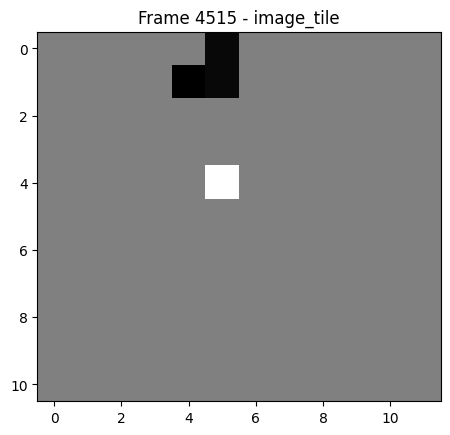

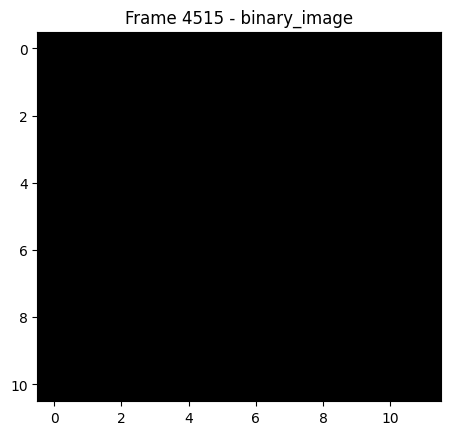

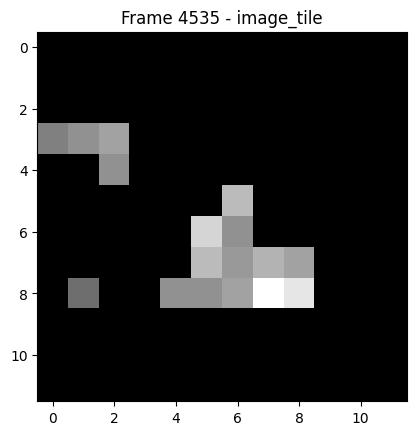

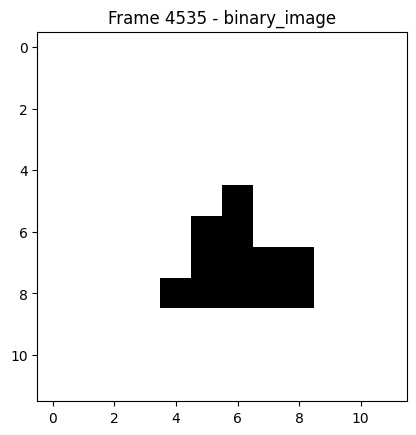

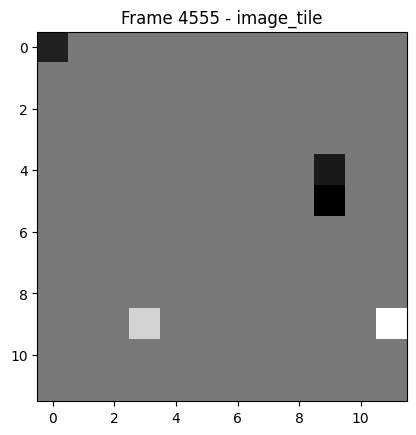

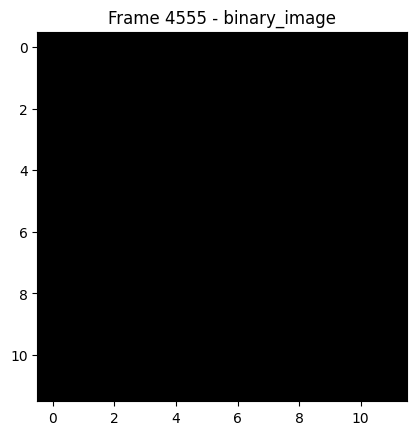

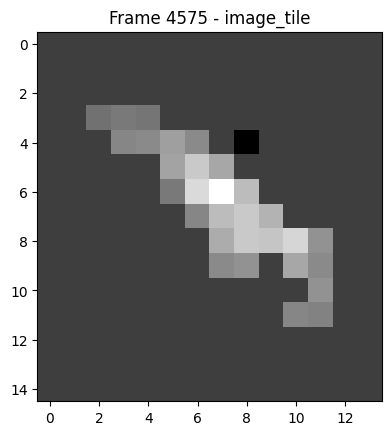

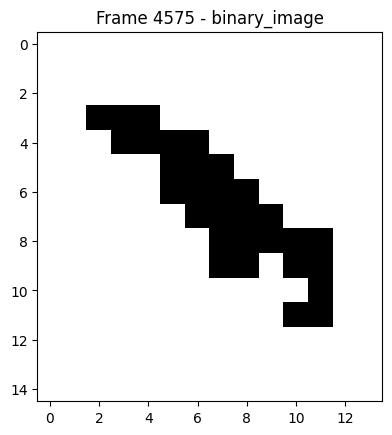

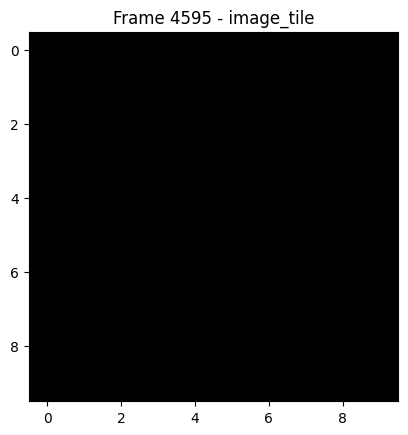

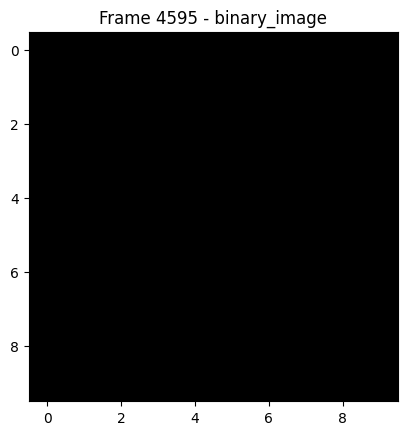

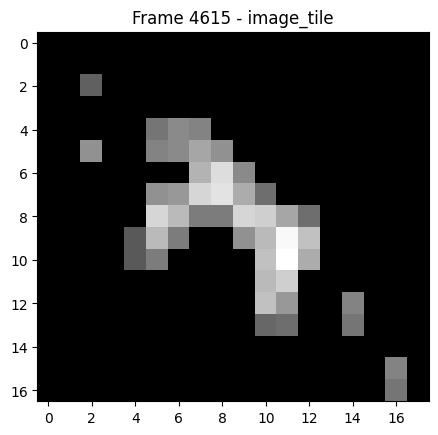

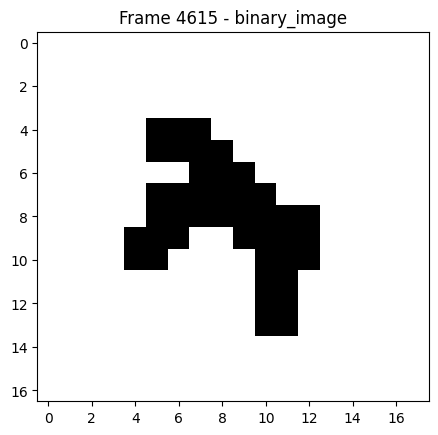

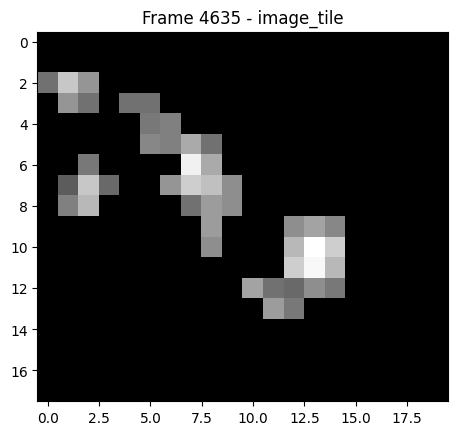

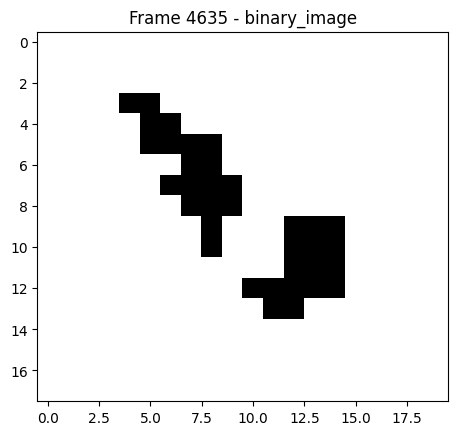

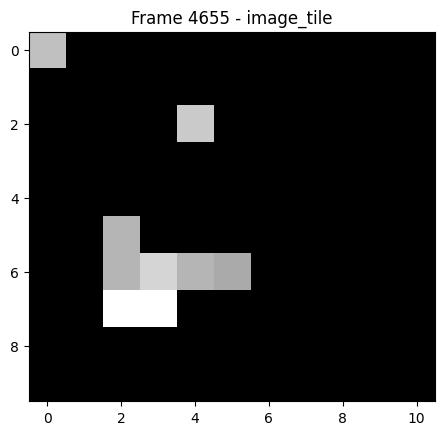

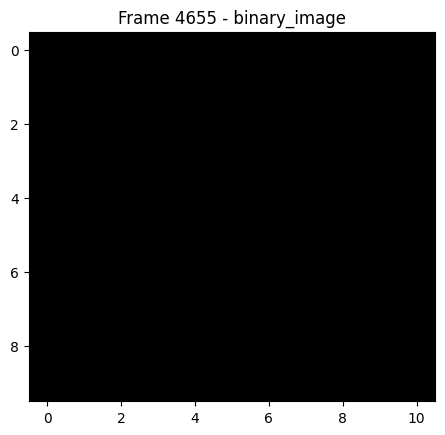

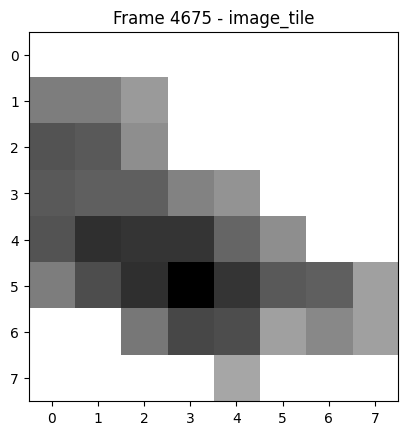

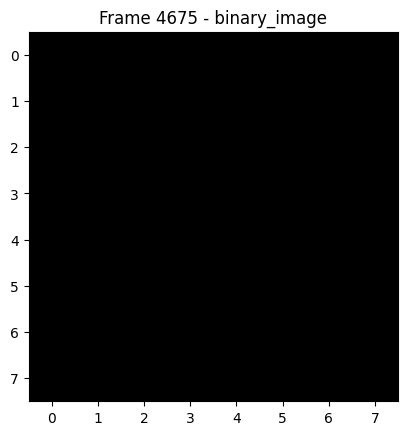

In [301]:
gen.plot_image_tiles_along_trajectory(7708, 20, feature_names=["image_tile", "binary_image"])

In [ ]:
gen.show_trajectory_numeric_features([6714, 2804, 6478], boxplot_split_thresholds=[1, 25])

# Compare features and patches

In [53]:
import ast

mmt_df = gen.mmt_dfs[0].copy()
# parse image_tile column to array
mmt_df['image_tile'] = mmt_df['image_tile'].apply(lambda x: np.array(ast.literal_eval(x), dtype=np.int32))

AttributeError: 'FeatureGenerator' object has no attribute 'mmt_dfs'

In [187]:
import cv2 as cv

def histogram(patch: np.ndarray):
    hist_raw = np.histogram(patch, bins=range(257))[0].reshape(-1, 1).astype(np.float32)
    hist_raw[127, 0] = 0.0 # remove the background bin
    return cv.normalize(hist_raw, hist_raw, alpha=0, beta=1, norm_type=cv.NORM_MINMAX).reshape(-1)

def sift_features(patch: np.ndarray):
    patch_uint8 = (patch * 255).astype(np.uint8)  # convert to 8-bit unsigned integer
    return cv.SIFT_create().detectAndCompute(patch_uint8, None)

def fft(patch: np.ndarray):
    patch = np.squeeze(patch)
    patch_uint8 = (patch * 255).astype(np.uint8)  # convert to 8-bit unsigned integer
    # patch_uint8 = cv.resize(patch_uint8, (64, 64))
    if patch_uint8.shape[0] < 3 or patch_uint8.shape[1] < 3:
        return []
    else:
        fft = np.fft.fft2(patch_uint8)
        return fft

# calculate features for mmts
mmt_df['histogram'] = mmt_df['image_tile'].apply(histogram)
mmt_df['fft'] = mmt_df['image_tile'].apply(fft)

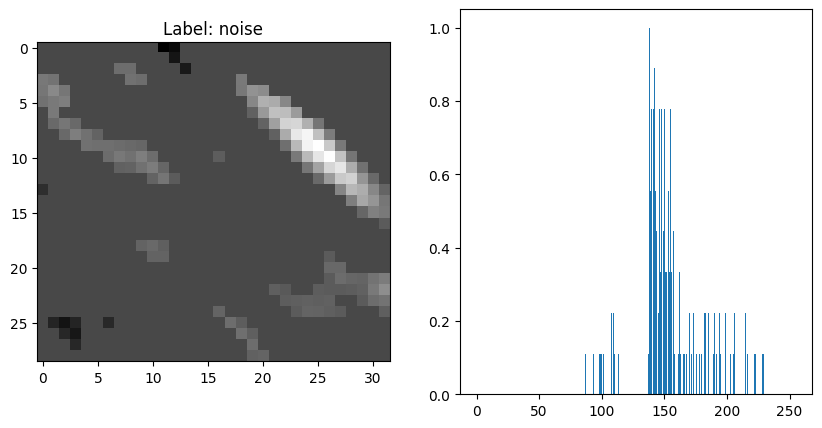

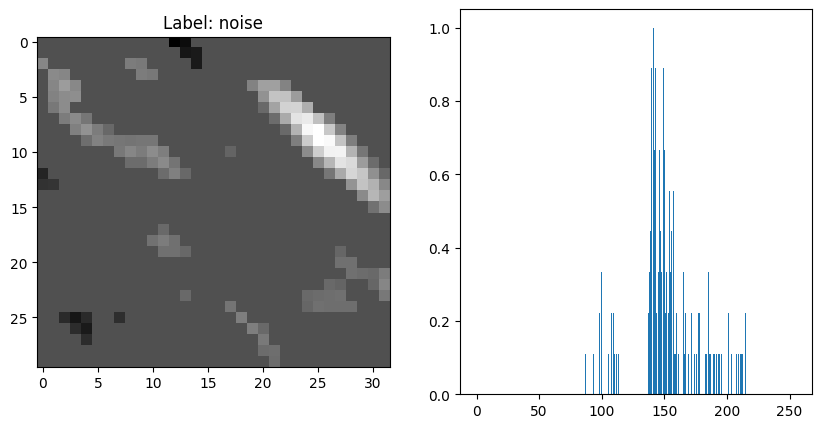

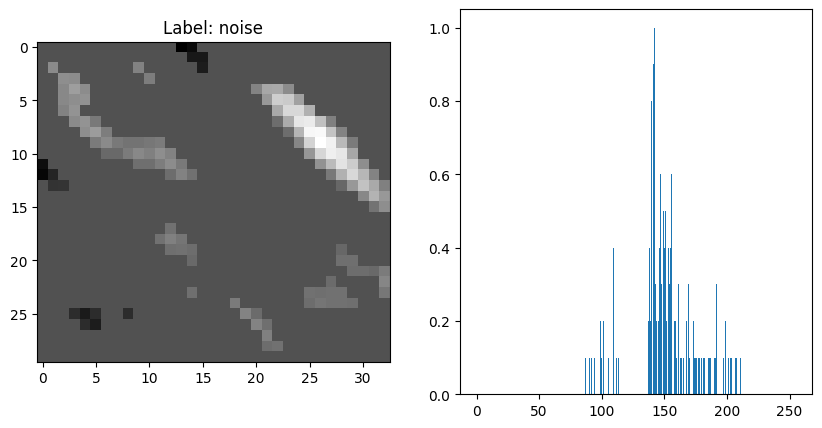

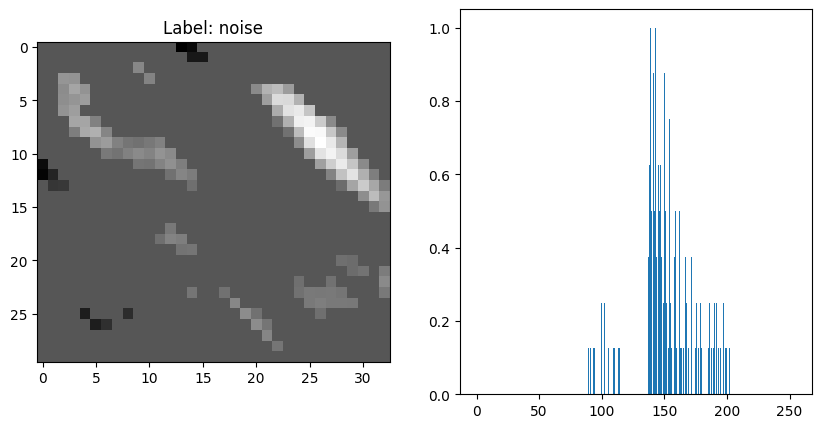

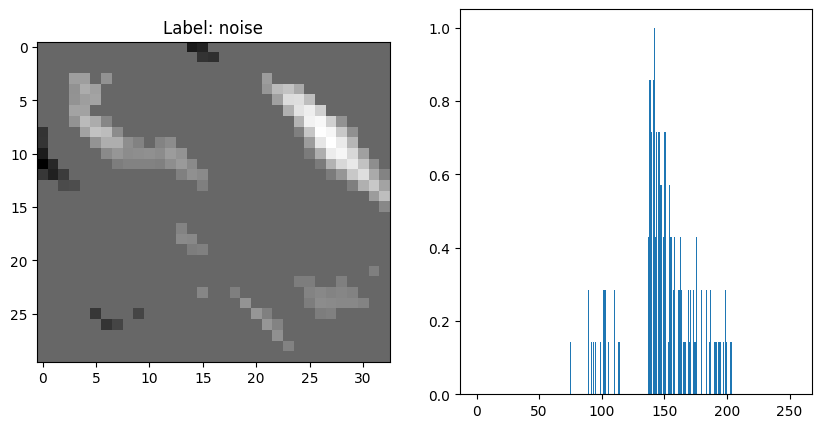

In [206]:
gen.measurements[0]

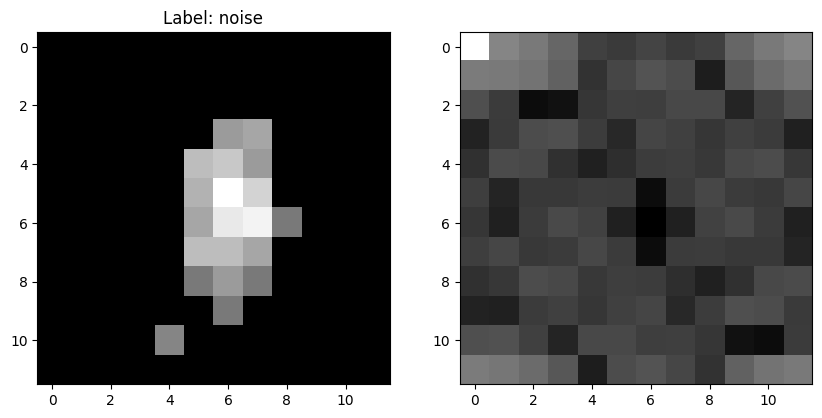

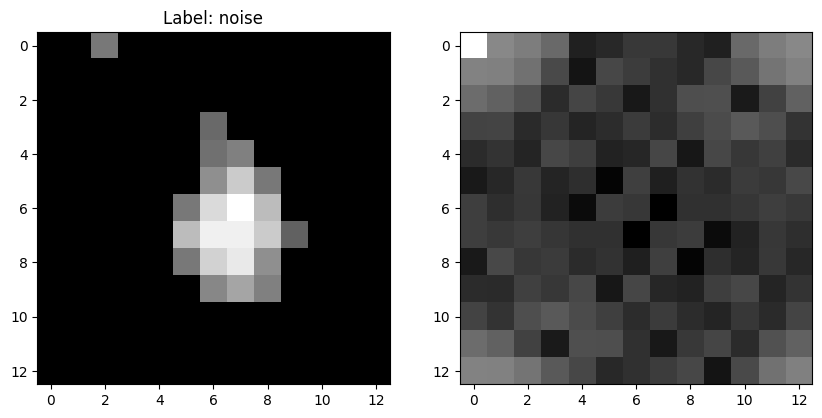

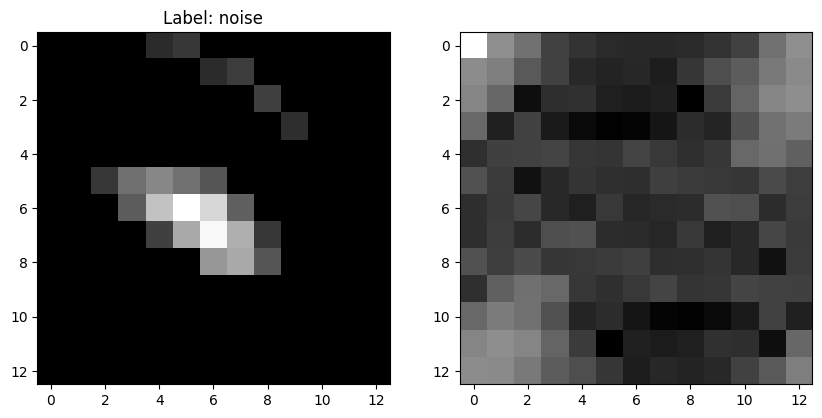

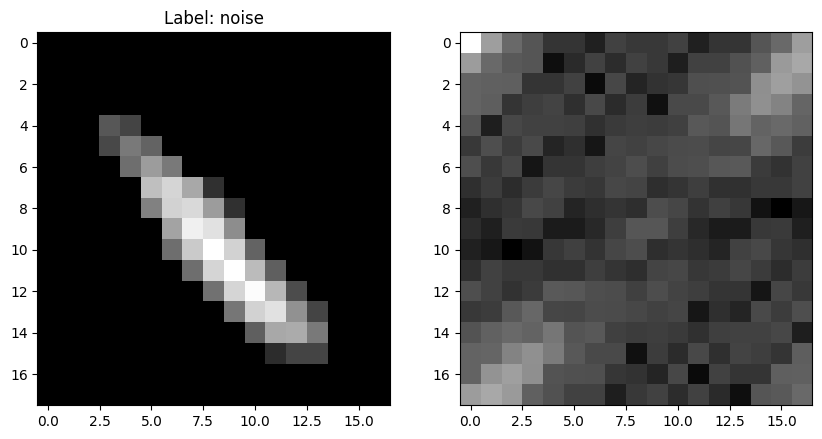

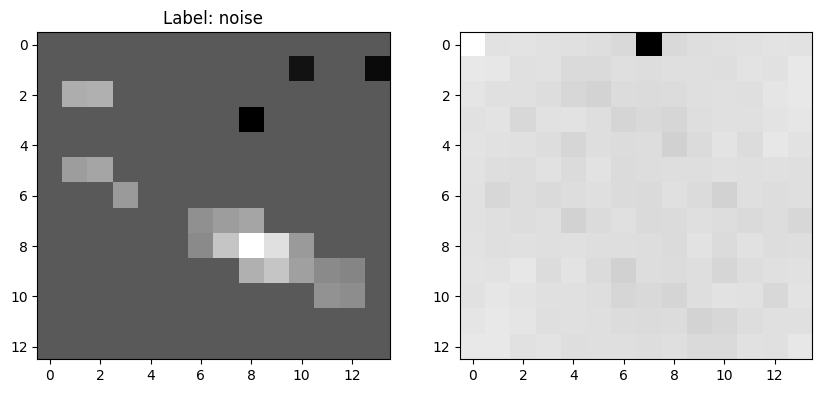

In [192]:
# plot some random patches with their ffts
for idx in indices:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    image_tile = np.squeeze(mmt_df.loc[idx, 'image_tile'])
    label = mmt_df.loc[idx, 'gt_label']
    ax[0].set_title(f'Label: {label}')
    ax[0].imshow(image_tile, cmap='gray')  # use grayscale colormap
    ax[1].imshow(np.log(np.abs(mmt_df.loc[idx, 'fft'])), cmap='gray')  # use grayscale colormap
    plt.show()

In [ ]:
# logistic regression based on some features

**PLOT PATHS**

In [43]:
def plot_path(identifier, data, alpha, color):
    ylim=[270, 0] 
    xlim=[0, 480]
    plt.plot(data.loc[data.id == identifier, "x"], data.loc[data.id == identifier, "y"], alpha=alpha, color=color)
    plt.xlim(xlim)
    plt.ylim(ylim)

In [135]:
identifier_counts = model_detections.id.value_counts()

In [136]:
filtered_df = model_detections[model_detections['id'].isin(identifier_counts[identifier_counts >= 20].index)]

In [137]:
filtered_twice = filtered_df
#filtered_twice = filtered_df[filtered_df['id'].isin(identifier_counts[identifier_counts <= 360].index)]

In [138]:
def get_path(identifier, data):
    return data.loc[data.id == identifier, ["x", "y"]].to_numpy()

paths = []
paths_identifiers = []

for identifier in filtered_twice["id"].unique():
    path = get_path(identifier, filtered_df)
    paths.append(path)
    paths_identifiers.append(identifier)


In [139]:
paths_identifiers

[483,
 1619,
 1683,
 1970,
 2427,
 2688,
 2693,
 2760,
 2871,
 2875,
 2984,
 3062,
 3064,
 3229,
 3242,
 3514,
 3674,
 4042,
 4474,
 4760,
 5231,
 5640,
 5768,
 5799,
 5904,
 5936,
 6110,
 6326,
 6735,
 7011,
 7082,
 7312,
 7602,
 7950,
 8572,
 8807,
 8988,
 9362,
 9389,
 9420,
 9500,
 9612,
 9619,
 9689,
 9692,
 9712,
 9747,
 9765,
 10193,
 10281,
 10588,
 10695,
 10760,
 10780,
 11263,
 11579,
 12307,
 12394,
 12484,
 12931,
 12943]

In [140]:
def z_standardize(path):
    mean = np.mean(path, axis=0)
    std = np.std(path, axis=0)
    return (path - mean) / std

In [141]:
standardized_paths = [z_standardize(path) for path in paths]

In [142]:
from dtaidistance import dtw_ndim

from dtaidistance import dtw, clustering


In [143]:
hier = clustering.Hierarchical(dtw_ndim.distance_matrix, dists_options={"window": 40})

In [144]:
hier_tree = clustering.HierarchicalTree(hier)

In [145]:
fitting_result = hier_tree.fit(standardized_paths)

In [73]:
fitting_result

{0: {0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34}}

In [146]:
hier_tree.linkage

[(42, 10, 0.3150674637738828, 0),
 (46, 11, 0.6224777187106855, 0),
 (62, 61, 0.8495667964397283, 0),
 (41, 32, 0.9018444363115276, 0),
 (64, 16, 1.1169773008345472, 0),
 (38, 63, 1.1286198477186027, 0),
 (37, 66, 1.6856513538155147, 0),
 (26, 67, 1.699918519638672, 0),
 (40, 27, 2.1913276109075808, 0),
 (31, 65, 2.730511469176569, 0),
 (45, 70, 2.816317687753955, 0),
 (69, 14, 3.0476147930312525, 0),
 (71, 15, 3.1299814858799375, 0),
 (56, 47, 3.4736388852440214, 0),
 (54, 36, 3.5094698909225843, 0),
 (74, 75, 4.6384418405936385, 0),
 (18, 68, 4.702891169570101, 0),
 (21, 73, 4.855332233773589, 0),
 (52, 23, 4.864974625935046, 0),
 (51, 12, 5.4944080994282745, 0),
 (39, 77, 5.69408741226771, 0),
 (22, 17, 5.8927746426858665, 0),
 (19, 4, 6.27770638156315, 0),
 (82, 72, 6.394890646631817, 0),
 (44, 78, 6.4139289040402865, 0),
 (53, 49, 6.627627740356647, 0),
 (30, 29, 6.756760771970712, 0),
 (59, 5, 7.720056640702918, 0),
 (60, 85, 7.834417408765528, 0),
 (88, 0, 7.907171780337212, 0),

In [147]:
from scipy.cluster.hierarchy import dendrogram

In [148]:
len(paths)

61

In [149]:
hier_tree.linkage

[(42, 10, 0.3150674637738828, 0),
 (46, 11, 0.6224777187106855, 0),
 (62, 61, 0.8495667964397283, 0),
 (41, 32, 0.9018444363115276, 0),
 (64, 16, 1.1169773008345472, 0),
 (38, 63, 1.1286198477186027, 0),
 (37, 66, 1.6856513538155147, 0),
 (26, 67, 1.699918519638672, 0),
 (40, 27, 2.1913276109075808, 0),
 (31, 65, 2.730511469176569, 0),
 (45, 70, 2.816317687753955, 0),
 (69, 14, 3.0476147930312525, 0),
 (71, 15, 3.1299814858799375, 0),
 (56, 47, 3.4736388852440214, 0),
 (54, 36, 3.5094698909225843, 0),
 (74, 75, 4.6384418405936385, 0),
 (18, 68, 4.702891169570101, 0),
 (21, 73, 4.855332233773589, 0),
 (52, 23, 4.864974625935046, 0),
 (51, 12, 5.4944080994282745, 0),
 (39, 77, 5.69408741226771, 0),
 (22, 17, 5.8927746426858665, 0),
 (19, 4, 6.27770638156315, 0),
 (82, 72, 6.394890646631817, 0),
 (44, 78, 6.4139289040402865, 0),
 (53, 49, 6.627627740356647, 0),
 (30, 29, 6.756760771970712, 0),
 (59, 5, 7.720056640702918, 0),
 (60, 85, 7.834417408765528, 0),
 (88, 0, 7.907171780337212, 0),

In [2]:
plt.figure(figsize=(25, 10))

dendrogram(hier_tree.linkage, labels=filtered_twice["id"].unique(), truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True, )
plt.savefig('wat.png')


NameError: name 'plt' is not defined

In [79]:
wat = clustering.KMeans(k=2).fit(standardized_paths)

{}
14.874085979527512


In [80]:
wat

({0: {0,
   2,
   3,
   4,
   6,
   7,
   8,
   10,
   12,
   13,
   15,
   16,
   17,
   20,
   21,
   23,
   24,
   26,
   27,
   28,
   29,
   31,
   32,
   33},
  1: {1, 5, 9, 11, 14, 18, 19, 22, 25, 30, 34}},
 3)

In [151]:
medoids = clustering.KMedoids(dtw_ndim.distance_matrix, dists_options={"window": 40}, k=2)

In [152]:
med_result = medoids.fit(standardized_paths)

In [153]:
med_result

{10: {2,
  3,
  5,
  7,
  10,
  11,
  13,
  14,
  17,
  18,
  23,
  24,
  25,
  26,
  27,
  29,
  30,
  33,
  37,
  38,
  39,
  42,
  46,
  47,
  52,
  56,
  57,
  59},
 32: {0,
  1,
  4,
  6,
  8,
  9,
  12,
  15,
  16,
  19,
  20,
  21,
  22,
  28,
  31,
  32,
  34,
  35,
  36,
  40,
  41,
  43,
  44,
  45,
  48,
  49,
  50,
  51,
  53,
  54,
  55,
  58,
  60}}

In [154]:
med_result.keys()

dict_keys([10, 32])

In [155]:
new_fish = []
clusters = wat[0]
for i, identifier in enumerate(paths_identifiers):
    if i in clusters.get(1, []):
        new_fish.append(identifier)

In [224]:
def plot_path_numpy(data, alpha, color, text=""):
    ylim=[270, 0] 
    xlim=[0, 480]
    plt.plot(data[:,0], data[:,1], alpha=alpha, color=color)
    plt.text(x = data[0,0],y = data[0,1],s=text)
    plt.xlim(xlim)
    plt.ylim(ylim)

In [171]:
%matplotlib widget


In [225]:
plt.close()

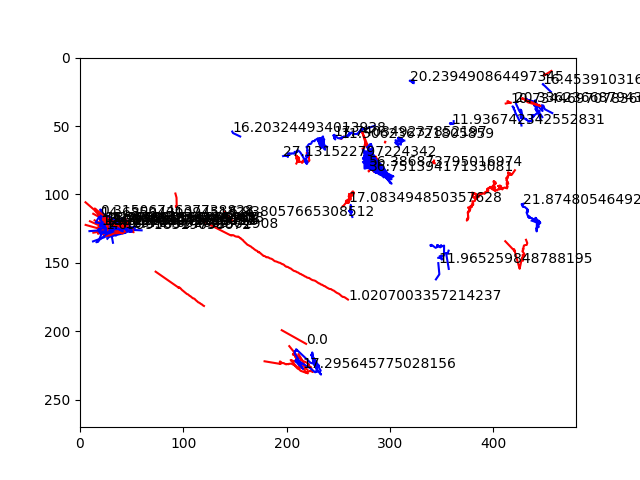

In [226]:
clusters = med_result
#clusters = wat[0]
for i in range(0, len(paths)):
    if i in clusters.get(10):
        color = "red"
    if i in clusters.get(32):
        color = "blue"
    #if i in clusters.get(0, []):
    #    color = "red"
    #if i in clusters.get(1, []):
    #    color = "blue"
    #if i in clusters.get(2, []):
    #    color = "green"
    #if i in clusters.get(3, []):
    #    color = "yellow"
    distance = dtw_ndim.distance(standardized_paths[i], standardized_paths[10], window=40)  if i % 2== 0 else ""
   # distance = ""

    plot_path_numpy(paths[i], 1, color, distance)

In [174]:
plot_path_numpy(paths[10], 1, "yellow")

In [ ]:
plot_path_numpy(paths[53], 1, "red")

In [ ]:
plot_path_numpy(paths[14], 0.2, "blue")

In [ ]:
standardized_paths[14]

In [ ]:
plt.plot(standardized_paths[14][:,0], standardized_paths[14][:,1], alpha=1, color=fish_color)


In [ ]:
plt.plot(standardized_paths[15][:,0], standardized_paths[15][:,1], alpha=1, color=fish_color)


In [ ]:
plt.plot(ground_truth["x"], ground_truth["y"], alpha=alpha, color=fish_color)


In [ ]:
len(paths)

In [ ]:
get_path(13410, model_detections)

In [ ]:
path = model_detections[model_detections['id']==13410][["x", "y"]].to_numpy()

In [ ]:
another_path = model_detections[model_detections['id']==14868][["x", "y"]].to_numpy()


In [ ]:
another_path.shape

In [ ]:
dtw_ndim.distance(path, another_path)

In [ ]:
dtw_ndim.distance(path, path)


In [ ]:
path.shape

In [ ]:
import numpy as np

In [ ]:
series1 = np.array([[0, 0],  # first point at t=0
                    [0, 1],  # second point at t=1
                    [2, 1],
                    [0, 1],
                    [0, 0]], dtype=np.double)


## Tested until here with new code

In [ ]:
few_fish_night_csv = "v2_output_02-23.csv"
many_fish_afternoon_csv = "v2_output_16-46.csv"
few_fish = pd.read_csv(few_fish_night_csv, delimiter=",")
many_fish = pd.read_csv(many_fish_afternoon_csv, delimiter=",")

value_counts_few = pd.DataFrame(few_fish.ID.value_counts()).reset_index().rename(columns={"index": "ID", "ID": "occurences"})
value_counts_many = pd.DataFrame(many_fish.ID.value_counts()).reset_index().rename(columns={"index": "ID", "ID": "occurences"})

In [ ]:
# value_counts_few.plot.bar(x='ID', y='occurences')
value_counts_few.head(200)

In [ ]:
amount = 100
alpha = 0.3
fish_color = "red"
object_color = "grey"

fig, [ax, ax1] = plt.subplots(nrows=2, ncols=1, sharex=True,  figsize=(10, 10))
plt.gca().invert_yaxis()

data = few_fish
for object in value_counts_few.ID.tolist()[:amount]:
    color = object_color
    ax.plot(data.loc[data.ID == object, "x"], data.loc[data.ID == object, "y"], alpha=alpha, color=color)

data = many_fish
for object in value_counts_many.ID.tolist()[:amount]:
    color = object_color
    ax1.plot(data.loc[data.ID == object, "x"], data.loc[data.ID == object, "y"], alpha=alpha, color=color)


ax.set(ylabel='y',
       title="no fish \n" + few_fish_night_csv, ylim=[270, 0], xlim=[0, 480])
ax1.set(xlabel='x', title="many fish \n" + many_fish_afternoon_csv, ylim=[270, 0], xlim=[0, 480])
ax.set_aspect('equal', adjustable='box')
ax1.set_aspect('equal', adjustable='box')
fig.suptitle(f"Paths of {amount} longest lasting objects", fontsize=14)

line1 = ax.plot([],[], color=fish_color, label='Fish')
line2 = ax.plot([],[], color=object_color, label='Object')
ax.legend()
line1 = ax1.plot([],[], color=fish_color, label='Fish')
line2 = ax1.plot([],[], color=object_color, label='Object')
ax1.legend()

plt.show()

In [ ]:
many_fish_min_50 = many_fish.loc[many_fish.ID.isin(value_counts_many.loc[value_counts_many["occurences"]>50, "ID"])]

In [ ]:
many_fish_min_50.groupby("ID").apply(lambda x: np.polyfit(x.x, x.y, deg=1)[0]).reset_index().sort_values(0).plot.hist(x="ID", y=0, bins=50)

In [ ]:
few_fish_min_50 = few_fish.loc[few_fish.ID.isin(value_counts_few.loc[value_counts_few["occurences"]>50, "ID"])]

In [ ]:
few_fish_min_50.groupby("ID").apply(lambda x: np.polyfit(x.x, x.y, deg=1)[0]).reset_index().sort_values(0).plot.hist(x="ID", y=0, bins=30)